## Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/GI_exercices/GI2S4/AI_Project/"

In [3]:
#changing the working directory
%cd /content/gdrive/MyDrive/GI_exercices/GI2S4/AI_Project/

/content/gdrive/MyDrive/GI_exercices/GI2S4/AI_Project


In [4]:
!kaggle datasets download -d jangedoo/utkface-new

 98% 324M/331M [00:03<00:00, 106MB/s]
100% 331M/331M [00:03<00:00, 100MB/s]


In [5]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [1]:
!ls

AI_Project.ipynb  UTKFace


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [3]:
BASE_DIR = './UTKFace/'

## Load the Dataset

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|█████████████████████████████████| 23708/23708 [00:00<00:00, 394696.13it/s]


In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,./UTKFace/25_0_0_20170104214616710.jpg.chip.jpg,25,0
1,./UTKFace/25_1_1_20170112205215428.jpg.chip.jpg,25,1
2,./UTKFace/57_1_0_20170110120847680.jpg.chip.jpg,57,1
3,./UTKFace/49_1_0_20170104185034878.jpg.chip.jpg,49,1
4,./UTKFace/35_0_2_20170117191648050.jpg.chip.jpg,35,0


In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}



In [7]:
# Split data into training, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

## Exploratory Data Analysis

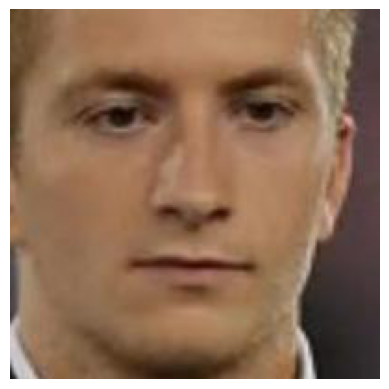

In [8]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<AxesSubplot: xlabel='age', ylabel='Density'>

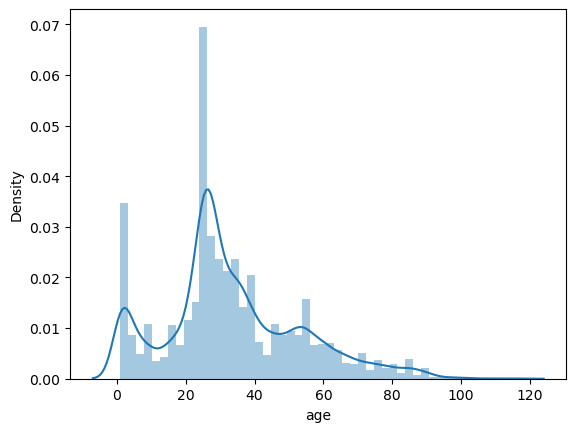

In [9]:
sns.distplot(df['age'])

In [10]:
df['gender'].value_counts()


0    12391
1    11317
Name: gender, dtype: int64

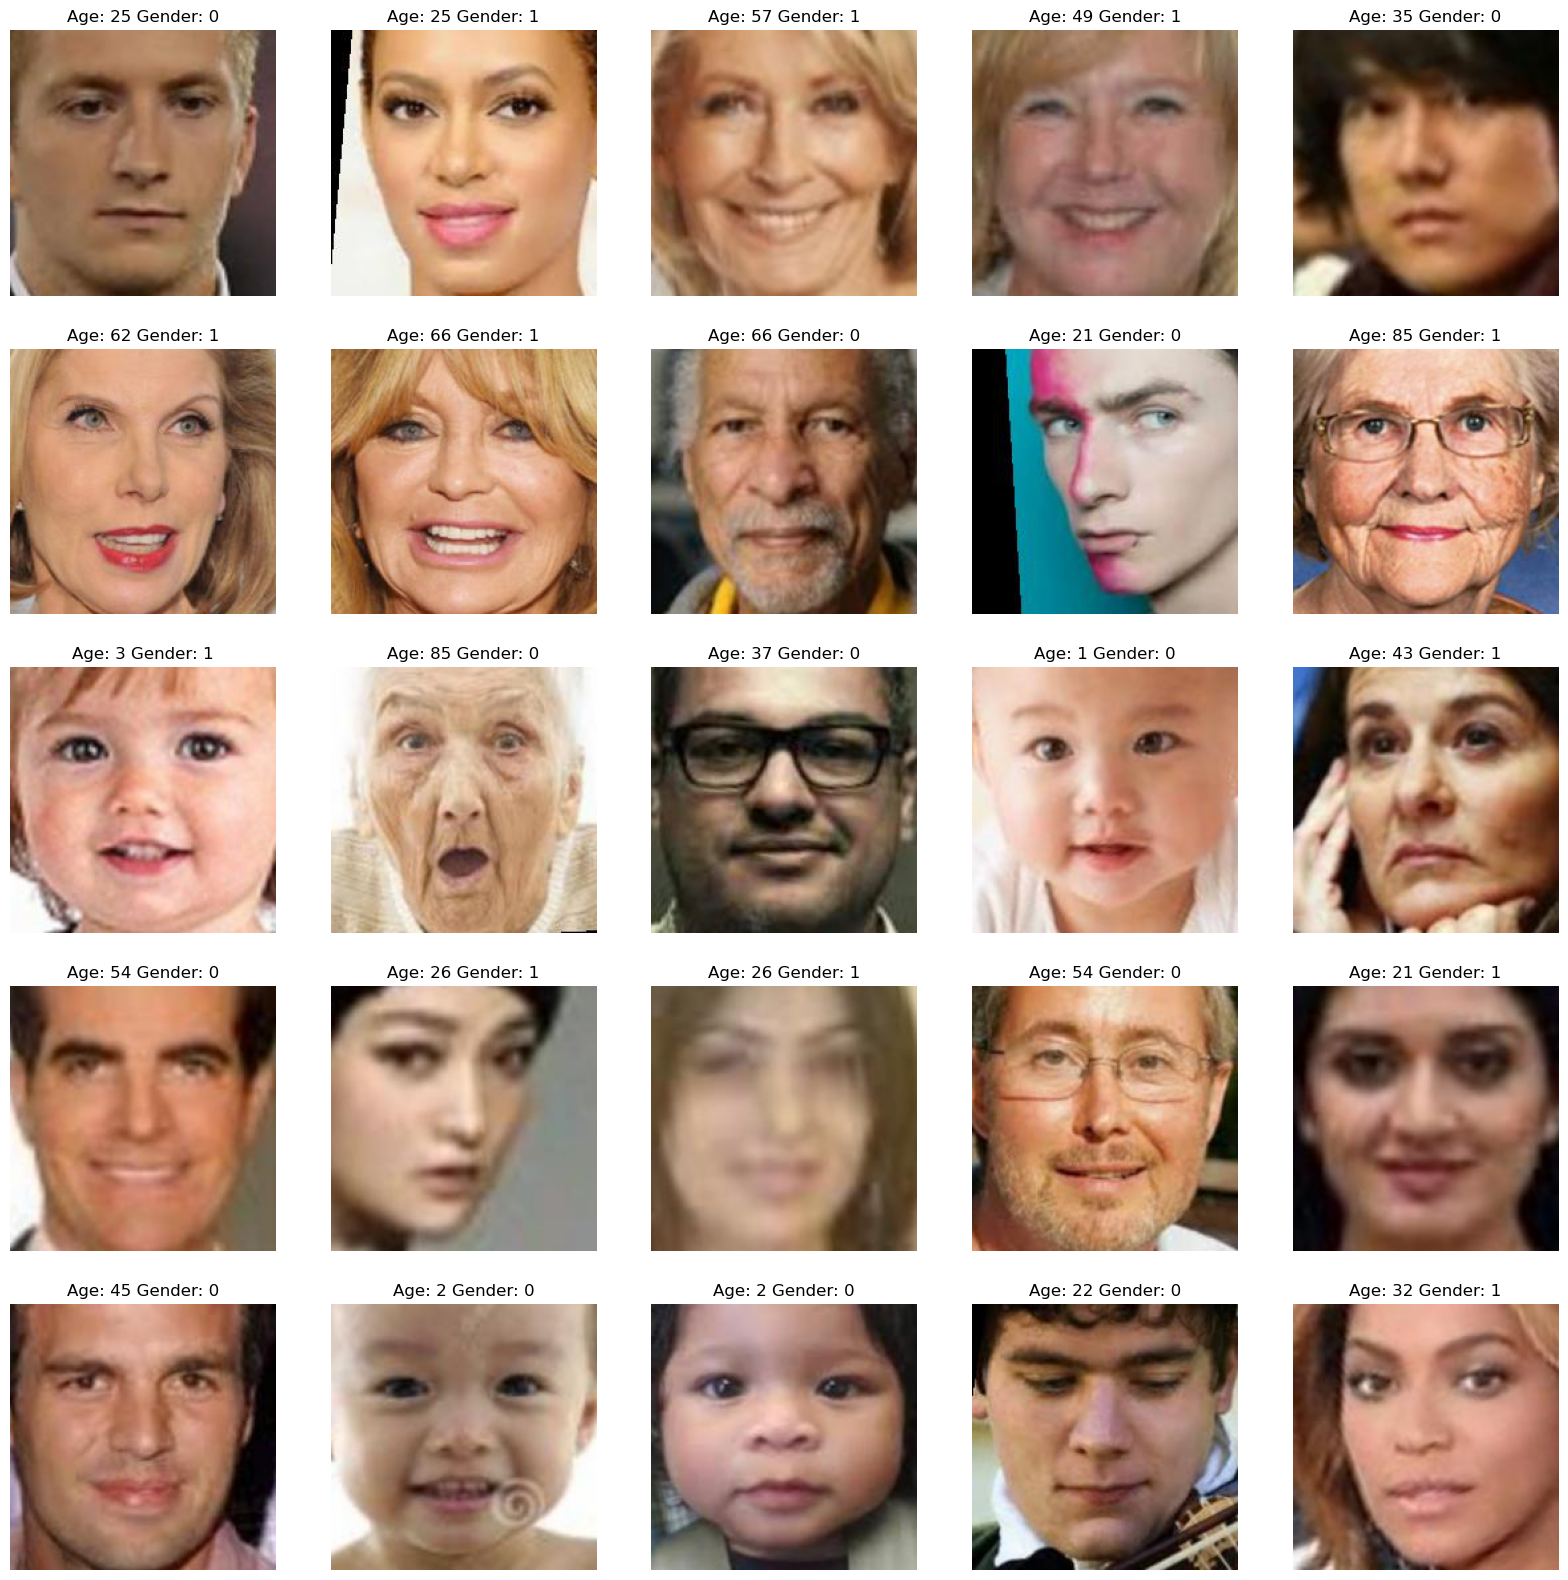

In [11]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender}")
    plt.axis('off')

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
X_train = extract_features(train_data['image'])
X_test = extract_features(test_data['image'])

100%|█████████████████████████████████████| 2371/2371 [00:02<00:00, 1096.16it/s]


In [14]:
X_train.shape


(21337, 128, 128, 1)

In [15]:
# normalize the images
X_train = X_train/255.0
X_test = X_test/255.0


In [16]:
y_gender_train = np.array(train_data['gender'])
y_age_train = np.array(train_data['age'])

y_gender_test = np.array(test_data['gender'])
y_age_test = np.array(test_data['age'])

In [17]:
input_shape = (128, 128, 1)

## Model Creation

In [18]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

2023-05-05 03:06:55.556553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 03:06:55.620542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 03:06:55.620739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 03:06:55.621479: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

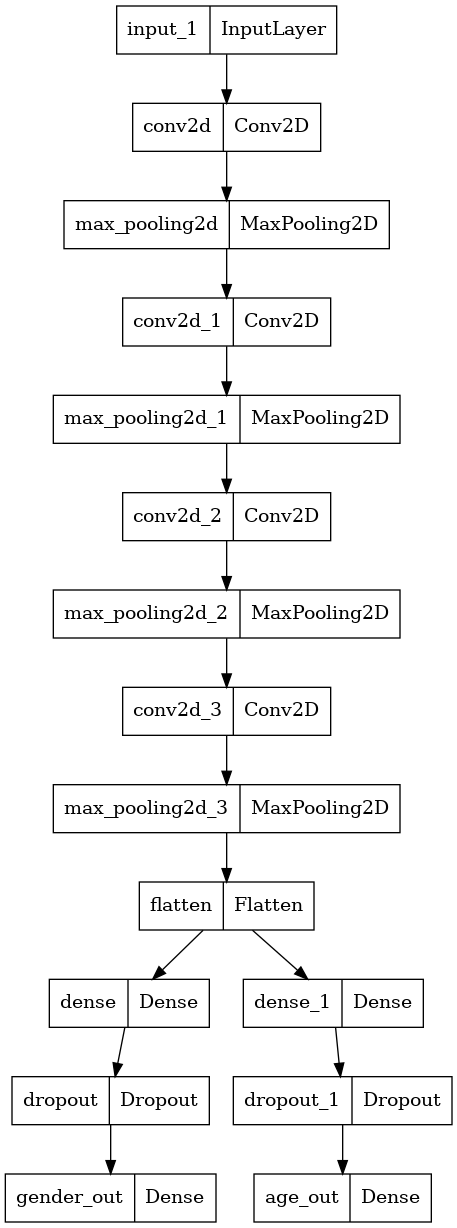

In [19]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
# train model
history = model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=30, validation_split=0.2)

2023-05-05 03:07:03.602073: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1118633984 exceeds 10% of free system memory.
2023-05-05 03:07:04.225821: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1118633984 exceeds 10% of free system memory.


Epoch 1/30


2023-05-05 03:07:06.168018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8700


534/534 [==============================] - 20s 31ms/step - loss: 15.9387 - gender_out_loss: 0.6799 - age_out_loss: 15.2588 - gender_out_accuracy: 0.5555 - age_out_accuracy: 0.0463 - val_loss: 13.2247 - val_gender_out_loss: 0.5320 - val_age_out_loss: 12.6927 - val_gender_out_accuracy: 0.7418 - val_age_out_accuracy: 0.0478
Epoch 2/30
534/534 [==============================] - 15s 29ms/step - loss: 11.9657 - gender_out_loss: 0.4860 - age_out_loss: 11.4796 - gender_out_accuracy: 0.7686 - age_out_accuracy: 0.0353 - val_loss: 11.2594 - val_gender_out_loss: 0.4486 - val_age_out_loss: 10.8108 - val_gender_out_accuracy: 0.7833 - val_age_out_accuracy: 0.0134
Epoch 3/30
534/534 [==============================] - 15s 29ms/step - loss: 10.2970 - gender_out_loss: 0.4142 - age_out_loss: 9.8828 - gender_out_accuracy: 0.8092 - age_out_accuracy: 0.0230 - val_loss: 9.5614 - val_gender_out_loss: 0.4001 - val_age_out_loss: 9.1614 - val_gender_out_accuracy: 0.8081 - val_age_out_accuracy: 0.0180
Epoch 4/30
5

## Plot the Results

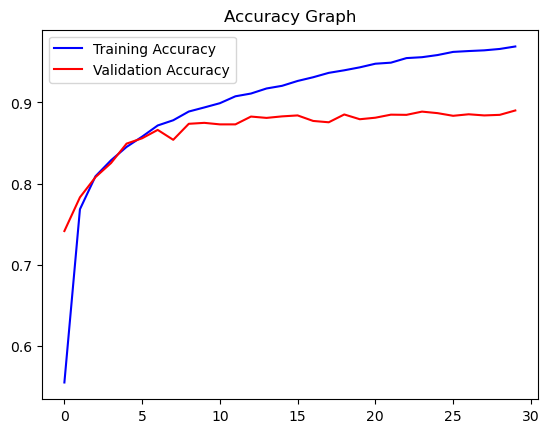

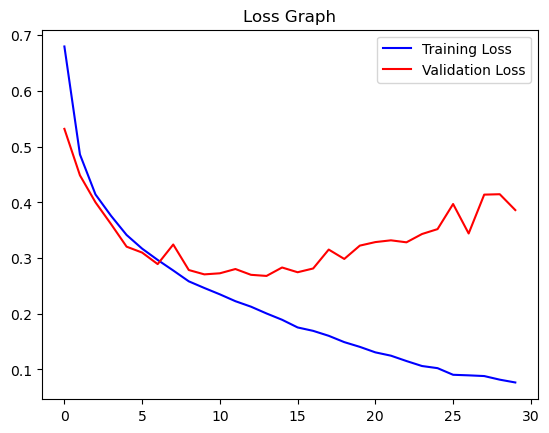

In [21]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

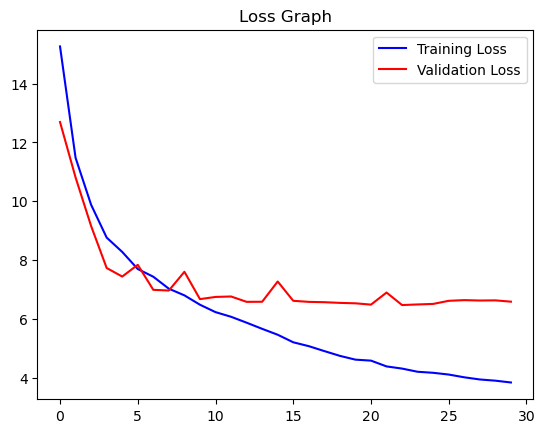

In [22]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [23]:
# evaluate the model on the test set
test_loss, test_gender_loss, test_age_loss, test_gender_acc, test_age_mae = model.evaluate(X_test, [y_gender_test, y_age_test], verbose=0)

# print the evaluation results
print('Test loss:', test_loss)
print('Test gender loss:', test_gender_loss)
print('Test age loss:', test_age_loss)
print('Test gender accuracy:', test_gender_acc)
print('Test age MAE:', test_age_mae)

Test loss: 7.112448215484619
Test gender loss: 0.36609822511672974
Test age loss: 6.746352195739746
Test gender accuracy: 0.8937157392501831
Test age MAE: 0.05103331804275513


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict gender for the test set
y_gender_pred = model.predict(X_test)[0]

# Convert probabilities to class labels (0 or 1)
y_gender_pred = np.round(y_gender_pred).astype(int)

# Calculate precision, recall, F1-score, and confusion matrix
print("Gender classification report:")
print(classification_report(y_gender_test, y_gender_pred))
print("Gender confusion matrix:")
print(confusion_matrix(y_gender_test, y_gender_pred))


Gender classification report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1254
           1       0.88      0.89      0.89      1117

    accuracy                           0.89      2371
   macro avg       0.89      0.89      0.89      2371
weighted avg       0.89      0.89      0.89      2371

Gender confusion matrix:
[[1124  130]
 [ 122  995]]


# Prediction with Test Data

Original Gender: Male Original Age: 28
Predicted Gender: Male Predicted Age: 43


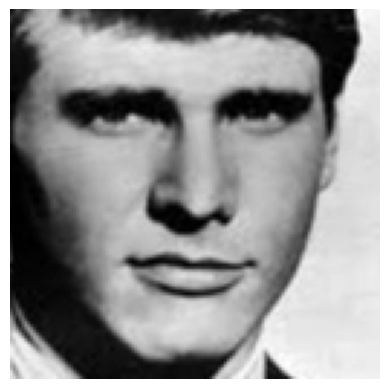

In [27]:
image_index = 100
print("Original Gender:", gender_dict[y_gender_test[image_index]], "Original Age:", y_age_test[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 26
Predicted Gender: Male Predicted Age: 24


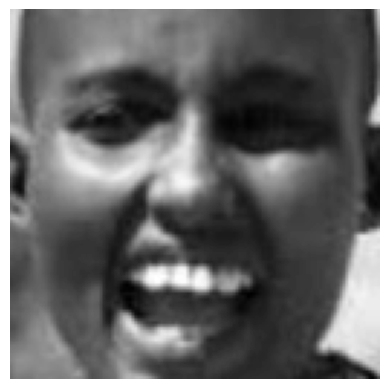

In [28]:
image_index = 200
print("Original Gender:", gender_dict[y_gender_test[image_index]], "Original Age:", y_age_test[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 40
Predicted Gender: Male Predicted Age: 43


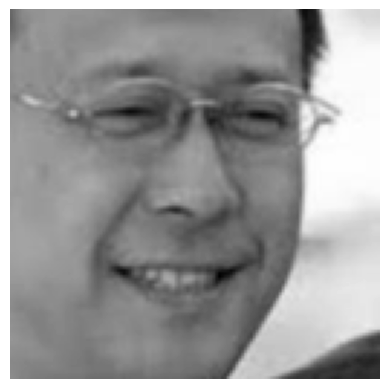

In [29]:
image_index = 210
print("Original Gender:", gender_dict[y_gender_test[image_index]], "Original Age:", y_age_test[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128), cmap='gray');